# Customer Segmentation Report

In [1]:
%matplotlib inline
import pickle

# data processing
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Cluster Explainability
import shap

# Import Data

In [2]:
# load the local dataset 
df = pd.read_csv('../data/bank_customer_dataset.csv')

df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# Load Model Artifacts

In [3]:
with open('../artifacts/numeric_imputer.pickle', 'rb') as filename: # trained model to impute missing numeric data
    numeric_imputer = pickle.load(filename)

with open('../artifacts/capper.pickle', 'rb') as filename: # trained model to cap outliers
    capper = pickle.load(filename)   

with open('../artifacts/model.pickle', 'rb') as filename: # trained random forrest classifier
    model = pickle.load(filename)

# Transform Dataset

In [4]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df.select_dtypes(include=numerics).columns.to_list()

In [5]:
# impute mising numeric features
df_numeric = pd.DataFrame(
    numeric_imputer.transform(df[numeric_columns]), 
    columns=numeric_columns, 
    index=df.index)

df = df_numeric.copy()

# remove outliers
df[numeric_columns] = capper.transform(df[numeric_columns])

# predict cluster
labels = model.predict(df)

# add cluster label to df
df['cluster'] = labels

df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0,1
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0,0
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0,0
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,311.800297,0.000000,12.0,0
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0,1


# Data Visualization

In [6]:
# Cluster Counts
df['cluster'].value_counts()

0    6594
1    1816
2     540
Name: cluster, dtype: int64

## What does the Cluster Distribution Lool Like?

In [7]:
# Cluster Counts
cluster_labels = []
for c in df['cluster'].value_counts().index.tolist():
    if c == 0:
        label = 'Noise Cluster'
    else:
        label = 'Cluster ' + str(c)
    cluster_labels.append(label)

cluster_labels

['Noise Cluster', 'Cluster 1', 'Cluster 2']

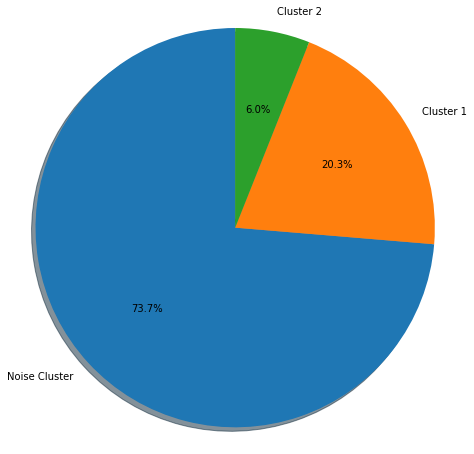

In [8]:
labels = cluster_labels
sizes = df['cluster'].value_counts().to_list()
explode = (0, 0, 0)  

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(
    x=sizes, 
    explode=explode, 
    labels=labels, 
    autopct='%1.1f%%',
    shadow=True, 
    startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

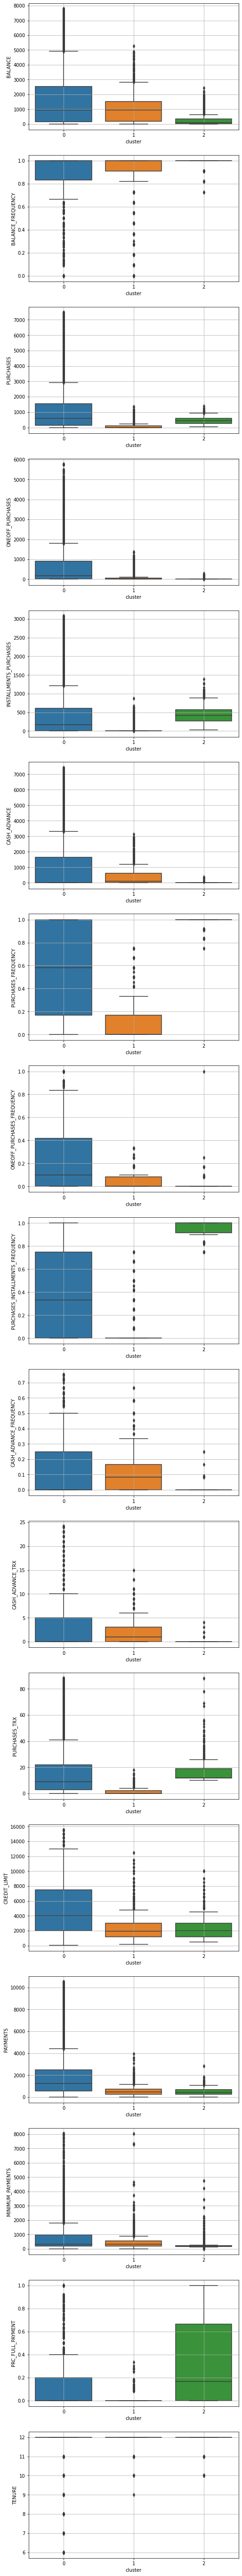

In [38]:
# boxplots for numeric columns

fig, ax = plt.subplots(
        figsize=(8,100), 
        nrows=len(numeric_columns), ncols=1, 
        sharex=False)

for n in range(len(numeric_columns)):
    sns.boxplot(
        data=df,
        x='cluster',
        y=numeric_columns[n],
        whis=1.0,
        ax=ax[n]
    )
    ax[n].grid()
#plt.show()

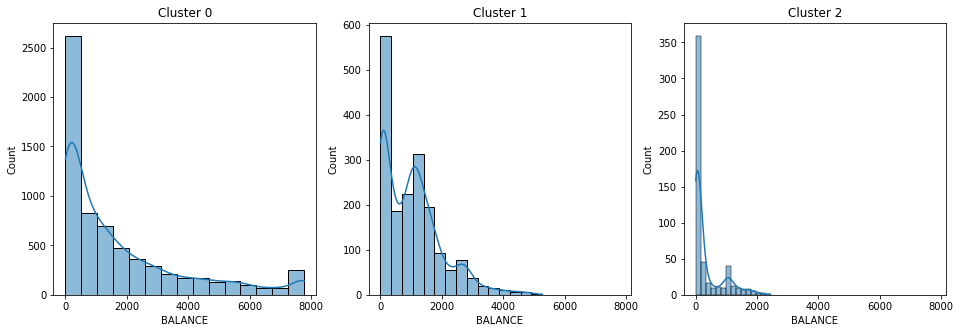

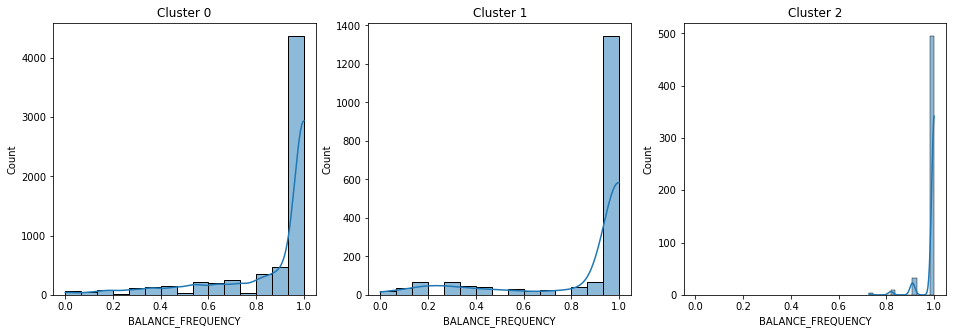

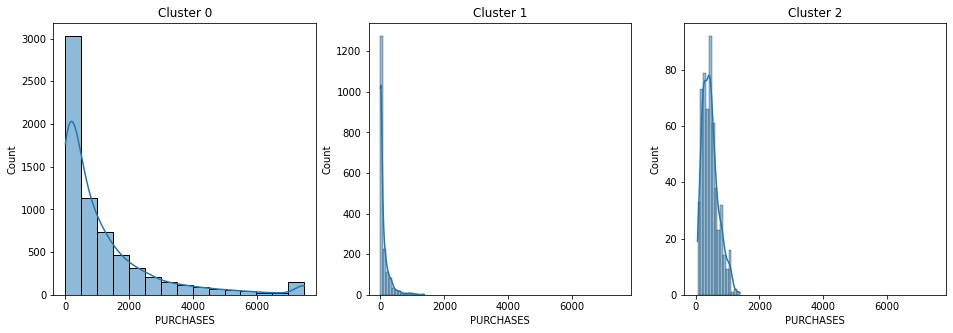

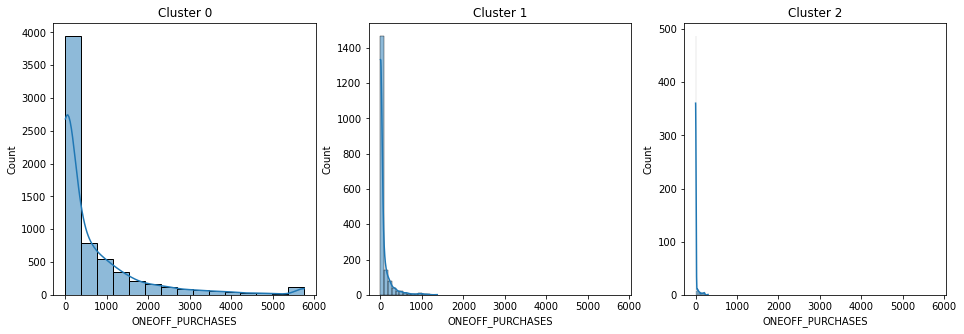

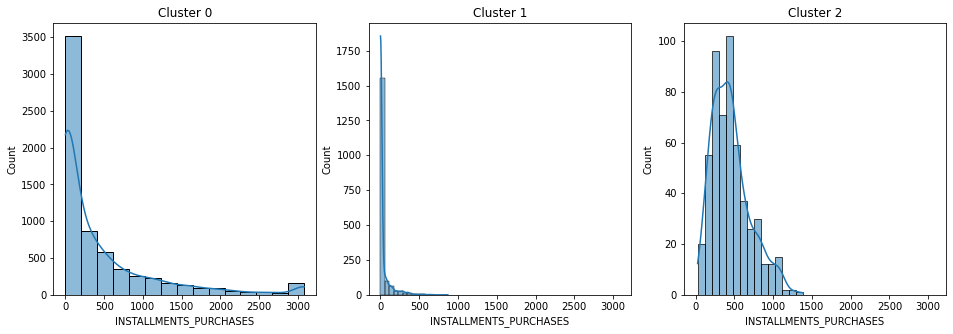

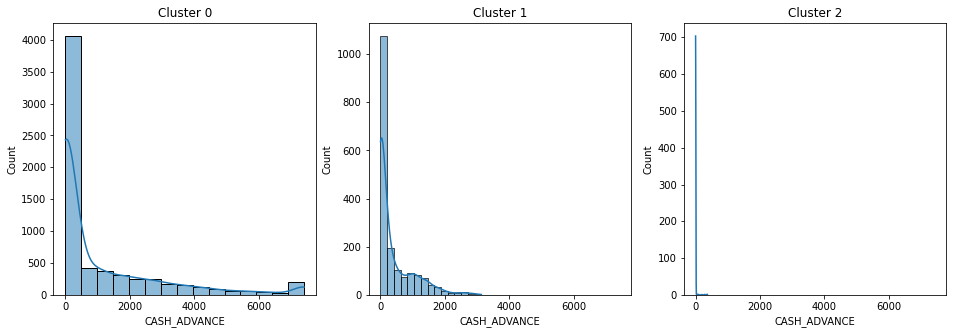

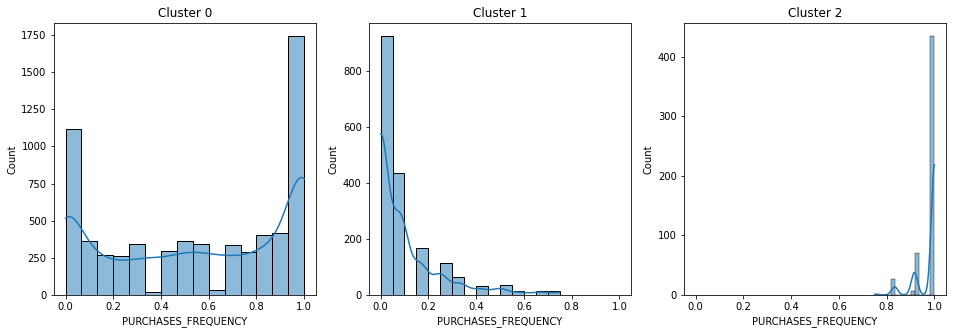

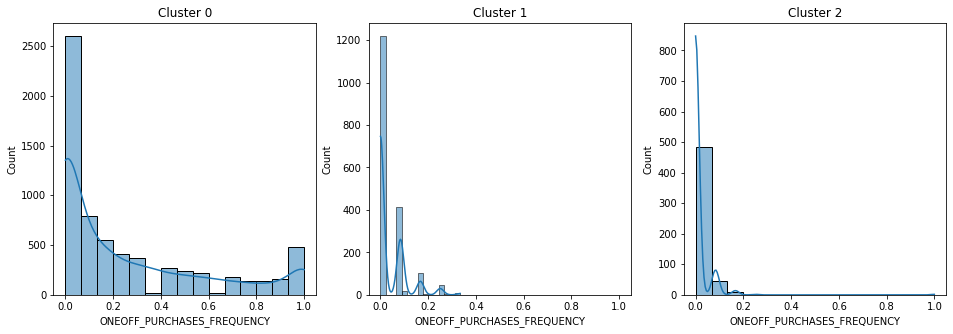

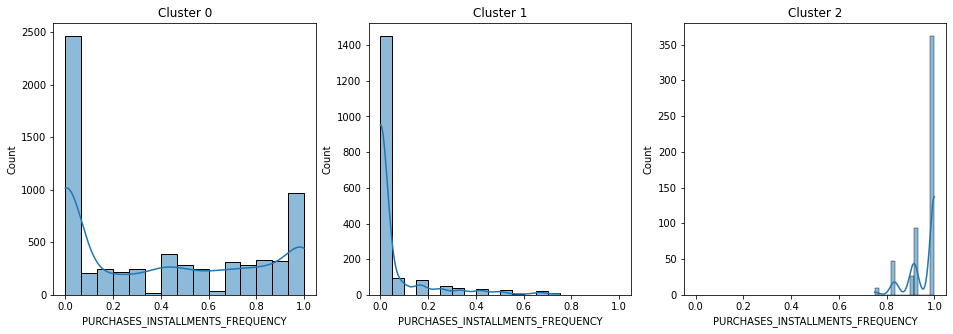

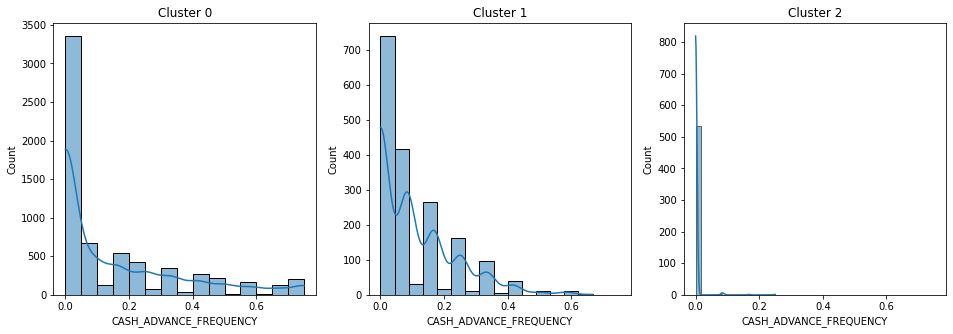

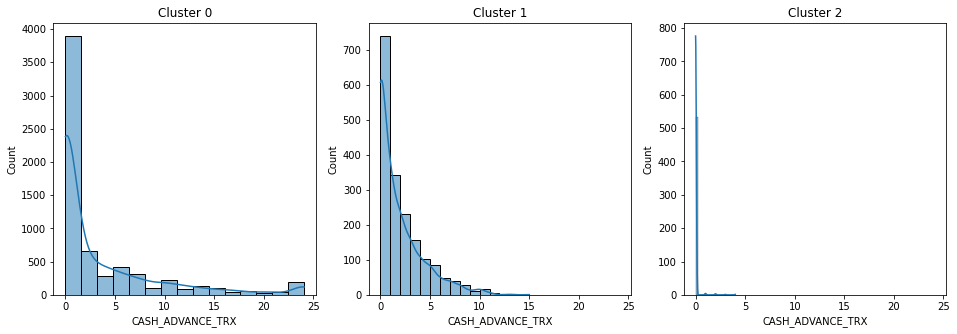

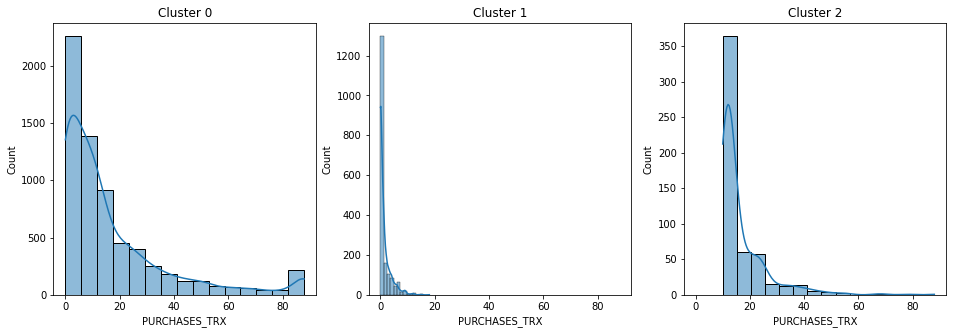

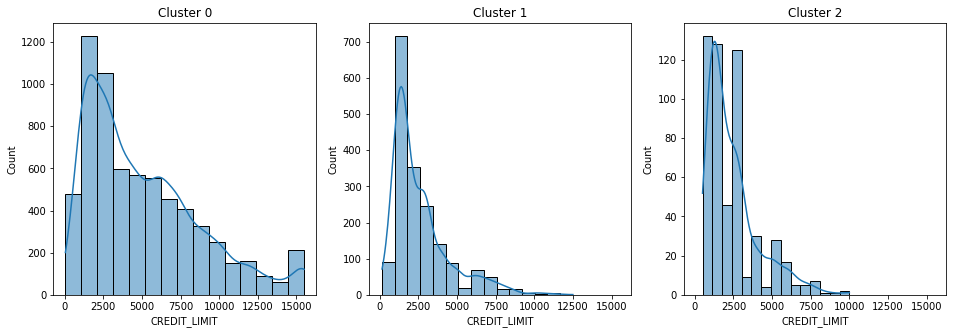

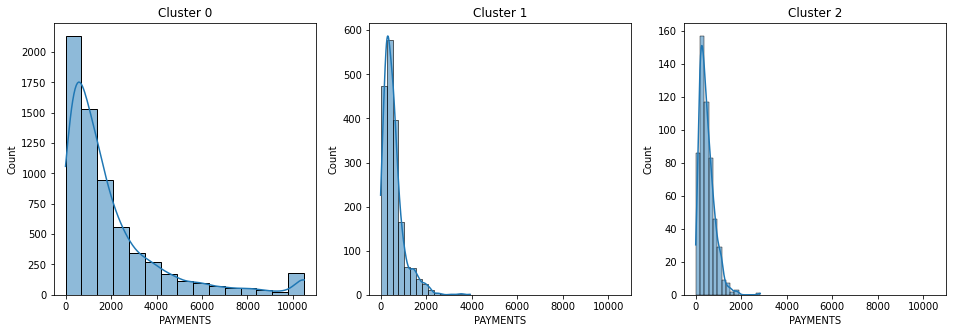

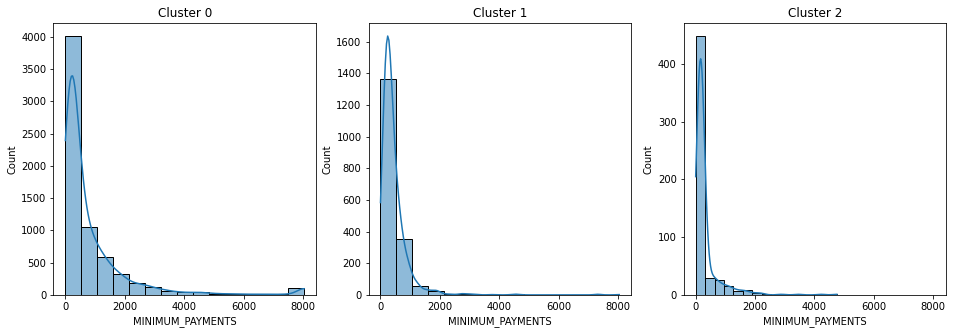

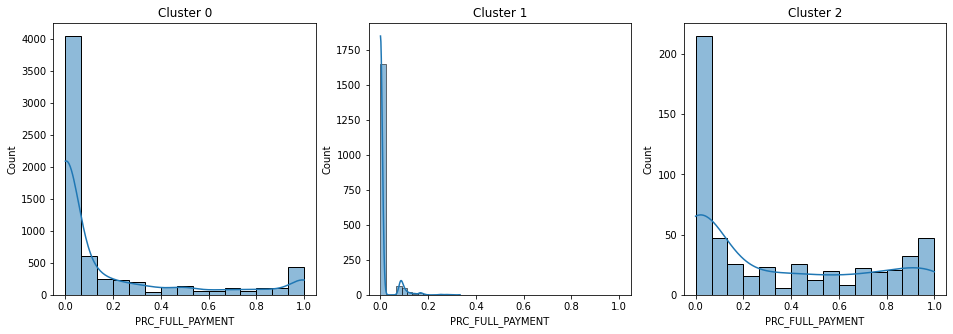

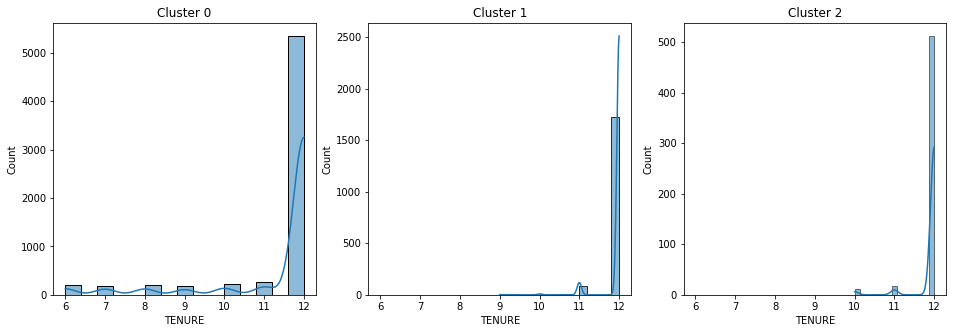

In [10]:
# visualize numeric features for each cluster
for feat in numeric_columns:

    fig, ax = plt.subplots(
        figsize=(16,5), 
        nrows=1, ncols=df['cluster'].nunique(), 
        sharex=True)
    
    for c in np.sort(df['cluster'].unique()):

        sns.histplot(
            data=df[df['cluster']==c], 
            x=feat,
            bins=15,
            kde=True,
            ax=ax[c])
        ax[c].set_title('Cluster '+str(c))
    plt.show()

# Determine Cluster Centers or What does the Average Customer in each Cluster Look Like?

In [23]:
# Cluster Centers
df.groupby(by='cluster').median()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,937.806150,1.0,582.895,178.815,163.48,0.000000,0.583333,0.1,0.333333,0.000000,0.0,9.0,4000.0,1232.78107,327.270197,0.000000,12.0
1,958.125169,1.0,0.000,0.000,0.00,96.134078,0.000000,0.0,0.000000,0.083333,1.0,0.0,1950.0,442.85716,311.800297,0.000000,12.0
2,73.222225,1.0,431.965,0.000,419.94,0.000000,1.000000,0.0,1.000000,0.000000,0.0,12.0,2000.0,408.75430,174.353481,0.166667,12.0


In [35]:
df[df['cluster']==1].describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.000000,1816.0
mean,1035.546829,0.858996,95.213464,66.314670,28.935964,395.591164,0.095924,0.038497,0.054528,0.107084,1.817181,1.389317,2605.726872,553.272844,440.410048,0.010432,11.946586,1.0
std,949.278626,0.279688,174.897075,162.419689,82.605647,585.121223,0.146631,0.064945,0.136365,0.123719,2.343187,2.222072,1884.177330,464.907827,506.769967,0.035399,0.245980,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,0.055880,0.000000,9.000000,1.0
25%,173.993413,0.909091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1200.000000,254.277300,191.052475,0.000000,12.000000,1.0
50%,958.125169,1.000000,0.000000,0.000000,0.000000,96.134078,0.000000,0.000000,0.000000,0.083333,1.000000,0.000000,1950.000000,442.857160,311.800297,0.000000,12.000000,1.0
75%,1505.001170,1.000000,118.330000,56.175000,0.000000,602.749898,0.166667,0.083333,0.000000,0.166667,3.000000,2.000000,3000.000000,709.800555,532.409845,0.000000,12.000000,1.0
max,5269.761999,1.000000,1370.000000,1370.000000,868.000000,3130.155158,0.750000,0.333333,0.750000,0.666667,15.000000,18.000000,12500.000000,3929.643369,8031.973420,0.333333,12.000000,1.0


# Explain Clusters

In [13]:
# Tree Explainer
explainer = shap.TreeExplainer(
    model = model.best_estimator_,
    output = 'probability')

In [14]:
X = df.iloc[:,:-1].sample(1000)
shap_values = explainer.shap_values(X)

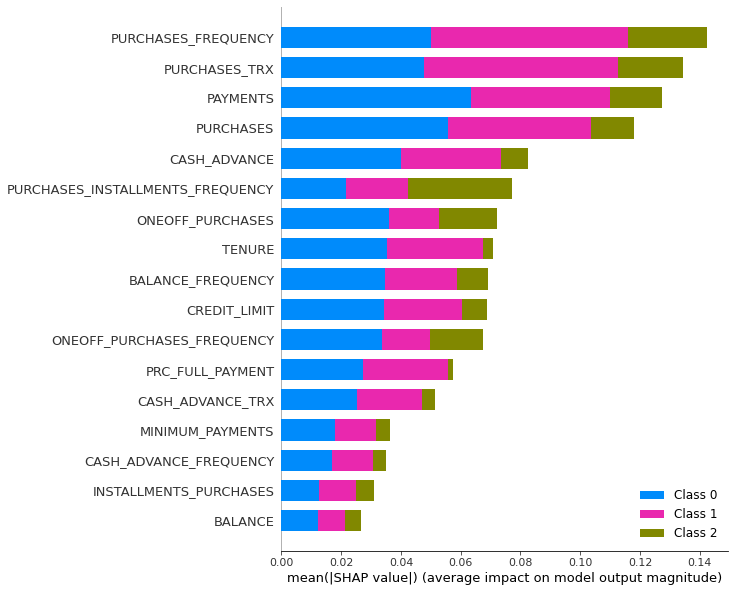

In [15]:
fig = shap.summary_plot(
    shap_values = shap_values, 
    features = X,
    sort=True,
    plot_size=(8.0,10.0)
    )
fig

# Explain Single Class vs Rest

In [48]:
cluster =  2

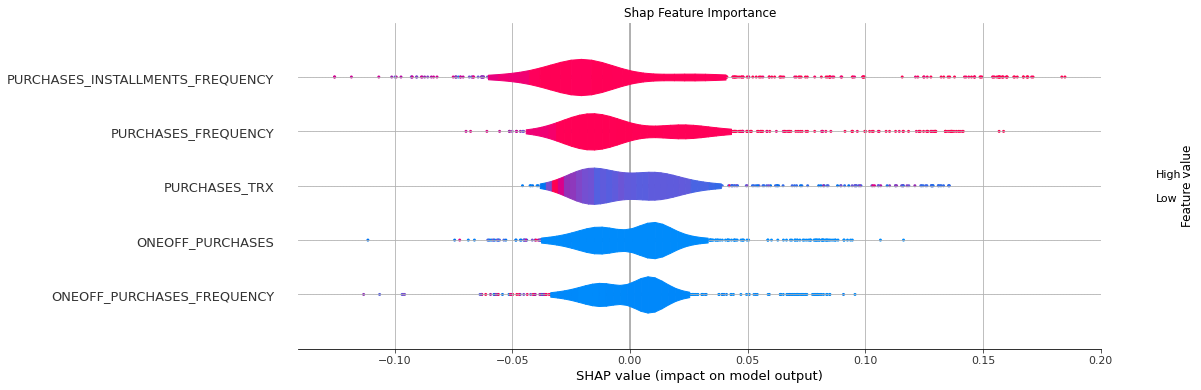

In [49]:
shap.summary_plot(
    shap_values = shap_values[cluster], 
    features = X,
    sort=True,
    plot_size=(18.0,6.0),
    show=False,
    max_display=5,
    plot_type='violin'
    )
ax=plt.gca()
ax.set_title('Shap Feature Importance')
ax.grid()
fig = plt.gcf()
plt.show()
